In [54]:
import warnings
from operator import itemgetter
import os
from os import path

import numpy as np
from numpy import nan # so eval() with nan works
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy
from scipy import optimize
from scipy import stats as spstats
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn import metrics as skmetrics

import allen_v1dd.stimulus_analysis.analysis_tools as at
from allen_v1dd.stimulus_analysis.analysis_tools import iter_plane_groups, get_roi_id
from allen_v1dd.stimulus_analysis.dg_models import *
from allen_v1dd.stimulus_analysis.dg_models import plotting
from allen_v1dd.stimulus_analysis.dg_models.config import *

at.set_stylesheet()
at.set_analysis_file("/Users/chase/Desktop/stimulus_analyses_v2.h5")

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# Load models and fits
model_config = get_model_config()
models = instantiate_models(model_config)
model_df = load_evaluation_df(models)
fit_df = load_sig_fit_df(models, model_df)

Loading model 1
  Training if necessary...
  Trained and evaluated on 7464 ROIs
Loading model 2
  Training if necessary...
  Trained and evaluated on 7464 ROIs
Loading model 3
  Training if necessary...
  Trained and evaluated on 7464 ROIs
Loading model 4
  Training if necessary...
  Trained and evaluated on 7464 ROIs
Loading model 5
  Training if necessary...
  Trained and evaluated on 7464 ROIs


In [29]:
# Find ROIs best fit by model 5
roi_ids = fit_df.index[fit_df.best_model == 5]
print(len(roi_ids), "ROIs best fit by model 5")

585 ROIs best fit by model 5


In [125]:
fit_df.best_model.value_counts()

None    3324
1       1165
4       1052
3        761
5        585
2        577
Name: best_model, dtype: int64

In [212]:
# Test model 5 gradients
X = np.random.randn(20, 14)
y = np.random.randn(len(X))
x0 = np.array([0.02]*12 + [1]*3)

def obj_fn(weights):
    y_pred, y_pred_grad = models[5]._predict(X, weights, return_grad=True)
    return training.rss_loss(y_true=y, y_pred=y_pred, y_pred_grad=y_pred_grad)

scipy.optimize.check_grad(func=lambda w: obj_fn(w)[0], grad=lambda w: obj_fn(w)[1], x0=x0)

1.7794508673182384e-06

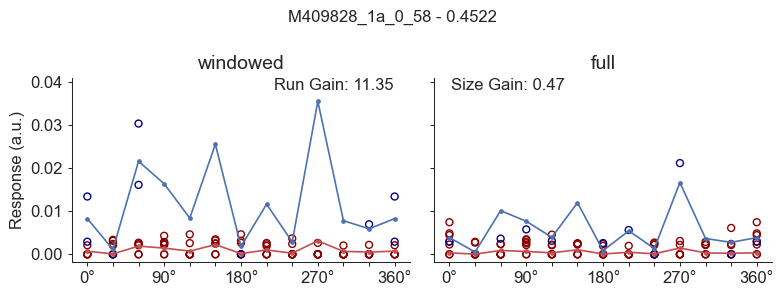

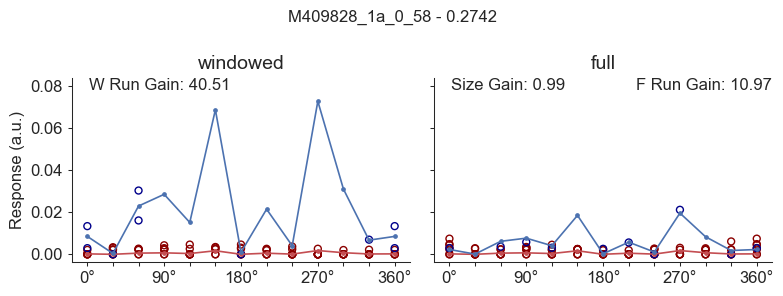

In [440]:
# For ROIs that are fitted by models 4 and 5, plot the score improvement
index_fn = lambda a, b: (a-b)/(a+b)

df = []
for roi_id in fit_df.index[~fit_df.model4.isna() & ~fit_df.model5.isna() & fit_df.best_model.isin([4, 5])]:
    run_gain = model_df.at[roi_id, "state_model4"][-1]
    size_gain_model5 = model_df.at[roi_id, "state_model5"][-3]
    run_gain_w = model_df.at[roi_id, "state_model5"][-2]
    run_gain_f = model_df.at[roi_id, "state_model5"][-1]
    df.append(dict(
        roi_id = roi_id,
        run_gain = run_gain,
        run_gain_w = run_gain_w,
        run_gain_f = run_gain_f,
        run_gain_max = max(run_gain_w, run_gain_f),
        size_gain = size_gain_model5,
        best_model = fit_df.at[roi_id, "best_model"]
    ))
df = pd.DataFrame(df)
df["lmi"] = index_fn(df.run_gain, 1)
df["lmi_w"] = index_fn(df.run_gain_w, 1)
df["lmi_f"] = index_fn(df.run_gain_f, 1)
df["smi"] = index_fn(df.size_gain, 1)
df

roi_ids = np.random.choice(df.roi_id[df.best_model == 4], size=1)

for roi_id in roi_ids:
    for model_key in (4, 5):
        fig, axs = plotting.build_figure(figtitle=f"{roi_id} - {fit_df.at[roi_id, f'model{model_key}']:.4f}", figscale=(4, 3))
        plotting.plot_trial_responses(roi_id, axs)
        
        # wrt = metrics_df.at[roi_id, "frac_resp_trials_w"]
        # frt = metrics_df.at[roi_id, "frac_resp_trials_f"]
        # for ax, rt in zip(axs, (wrt, frt)):
        #     ax.set_title(f"{ax.get_title()} - {rt:.2f}", fontsize=12)
        
        plotting.plot_model_fit(models, model_df, model_key=model_key, roi_id=roi_id, axs=axs)

In [441]:
df[df.best_model == 4].run_gain.median()

1.5432674388581533

Text(0.5, 0.98, '1082 ROIs whose best fit is either Model 4 or Model 5')

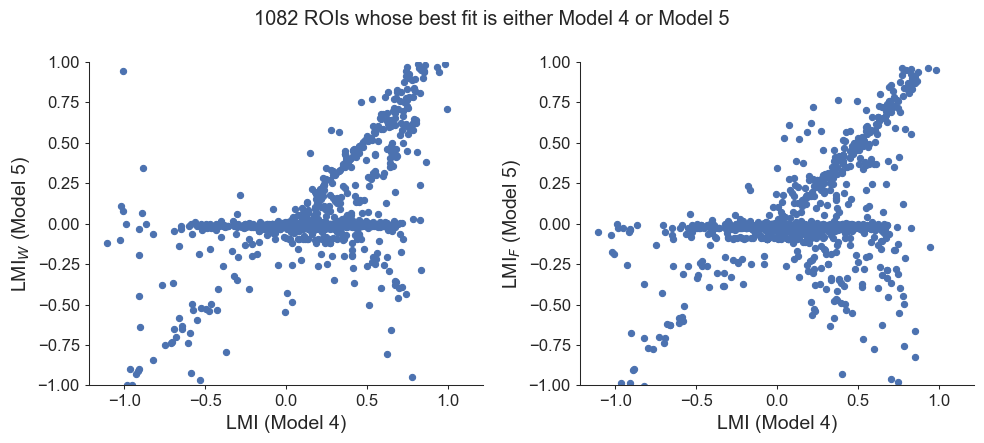

In [416]:
fig, axs = plt.subplots(figsize=(10, 4.5), ncols=2, tight_layout=True)
ax = axs[0]
ax.scatter(x=df.lmi, y=df.lmi_w, s=20)
ax.set_xlabel("LMI (Model 4)")
ax.set_ylabel("LMI$_W$ (Model 5)")

ax = axs[1]
ax.scatter(x=df.lmi, y=df.lmi_f, s=20)
ax.set_xlabel("LMI (Model 4)")
ax.set_ylabel("LMI$_F$ (Model 5)")


for ax in axs:
    ax.axis("equal")
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
fig.suptitle(f"{len(df)} ROIs whose best fit is either Model 4 or Model 5")

Text(0.5, 0, 'LMI_F (Model 5)')

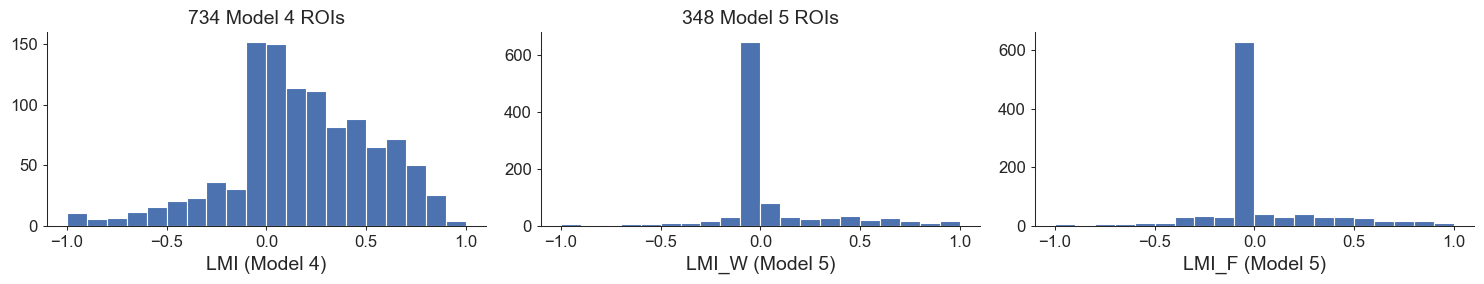

In [421]:
fig, axs = plt.subplots(figsize=(15, 3), ncols=3, tight_layout=True)
bins = np.arange(-1, 1.1, 0.1)

axs[0].hist(x=df.lmi, bins=bins)
axs[0].set_title(f"{len(df[df.best_model == 4])} Model 4 ROIs")
axs[0].set_xlabel("LMI (Model 4)")

axs[1].hist(x=df.lmi_w, bins=bins)
axs[1].set_title(f"{len(df[df.best_model == 5])} Model 5 ROIs")
axs[1].set_xlabel("LMI_W (Model 5)")

axs[2].hist(x=df.lmi_f, bins=bins)
axs[2].set_xlabel("LMI_F (Model 5)")

[autoreload of allen_v1dd.client.ophys_session failed: Traceback (most recent call last):
  File "/opt/anaconda3/envs/allen_v1dd/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/opt/anaconda3/envs/allen_v1dd/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 459, in superreload
    module = reload(module)
  File "/opt/anaconda3/envs/allen_v1dd/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/chase/Desktop/MindScope/allen_v1dd/src/allen_v1dd/client/ophys_session.py", line 12, in <module>
    from allen_v1dd.eye_tracking import eye_tracking_processing
  File "/Users/chase/Desktop/MindScope/allen_v1dd/src/allen_v1dd/e

,roi_id,run_gain,run_gain_w,run_gain_f,run_gain_max,size_gain,best_model,lmi,lmi_w,lmi_f,smi
1,M409828_11_2_1,12.262586,19.320192,-2.330272,19.320192,-0.181659,5,0.849200,0.901576,2.503452,-1.443968
2,M409828_11_2_15,5.293016,2.386888,0.557601,2.386888,-0.111498,5,0.682187,0.409487,-0.284026,-1.250979
4,M409828_11_3_18,10.350155,53.583401,-10.682915,53.583401,-0.117776,5,0.823791,0.963359,1.206549,-1.266998
6,M409828_11_3_24,3.275902,7.718230,2.843119,7.718230,4.269820,5,0.532262,0.770596,0.479589,0.620480
7,M409828_11_3_5,1.851939,-0.211979,1.899592,1.899592,31.778887,5,0.298723,-1.538004,0.310248,0.938985
...,...,...,...,...,...,...,...,...,...,...,...
1067,M409828_1e_0_168,4.319992,0.656960,4.134615,4.134615,3.763042,5,0.624060,-0.207030,0.610487,0.580100
1068,M409828_1e_0_20,1.093540,0.983270,0.970384,0.983270,0.918818,5,0.044680,-0.008435,-0.015031,-0.042308
1069,M409828_1e_0_33,2.104116,0.847723,2.077643,2.077643,2.014409,5,0.355694,-0.082414,0.350152,0.336520
1071,M409828_1e_0_51,0.956763,0.983336,0.970381,0.983336,0.918956,5,-0.022096,-0.008402,-0.015032,-0.042233


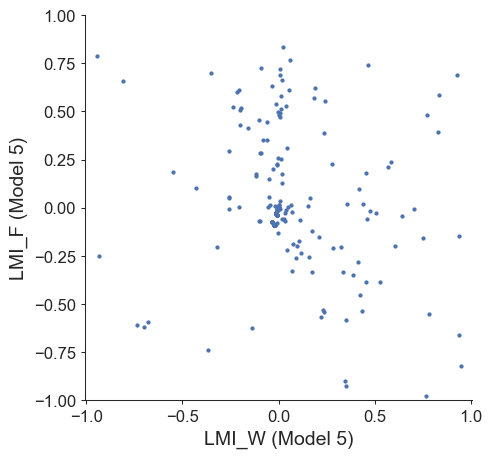

In [488]:
df5 = df[df.best_model == 5]
plt.figure(figsize=(5, 5))
plt.scatter(df5.lmi_w, df5.lmi_f, s=5)
plt.gca().axis("equal")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel("LMI_W (Model 5)")
plt.ylabel("LMI_F (Model 5)")

df5

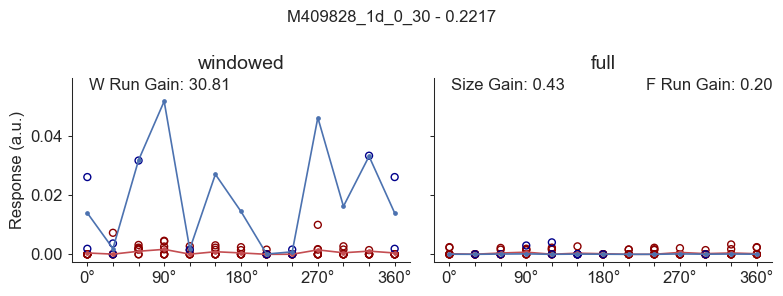

In [344]:
roi_id = np.random.choice(df.roi_id[lmi_fn(df.run_gain_max) >= 0.1])

fig, axs = plotting.build_figure(figtitle=f"{roi_id} - {fit_df.at[roi_id, f'model5']:.4f}", figscale=(4, 3))
plotting.plot_trial_responses(roi_id, axs)
plotting.plot_model_fit(models, model_df, model_key=model_key, roi_id=roi_id, axs=axs)

Text(0.5, 0, 'SMI (running) = index(L$_F$*S, L$_W$)')

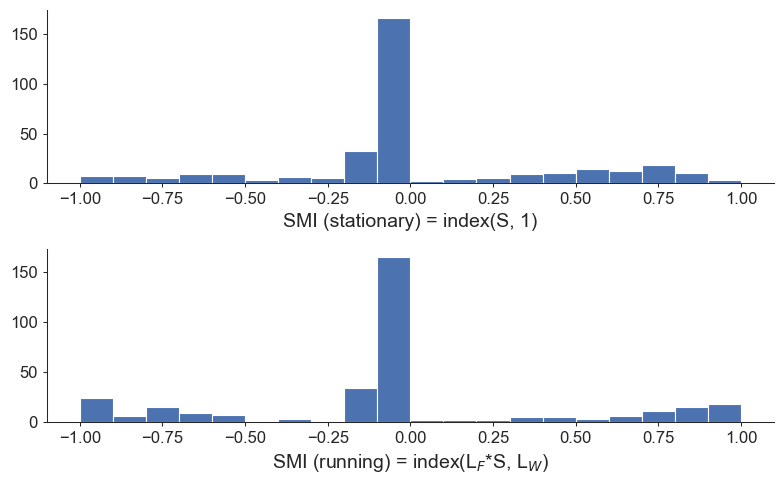

In [453]:
fig, axs = plt.subplots(figsize=(8, 5), nrows=2, tight_layout=True)

ax = axs[0]
ax.hist(df5.smi, bins=bins)
ax.set_xlabel("SMI (stationary) = index(S, 1)")

ax = axs[1]
smi_run = index_fn(df5.run_gain_f * df5.size_gain, df5.run_gain_w)
ax.hist(smi_run, bins=bins)
ax.set_xlabel("SMI (running) = index(L$_F$*S, L$_W$)")

0.28735632183908044

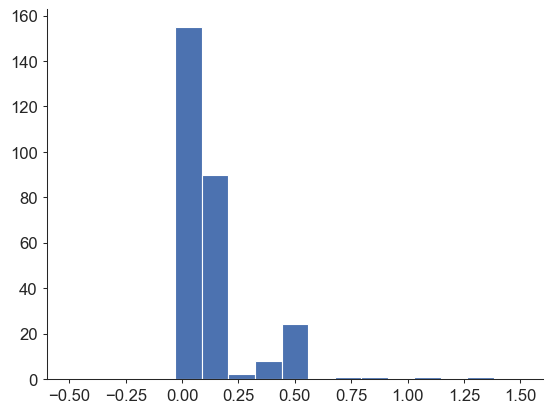

In [477]:
resp_largest_run = df5.run_gain_f*df5.size_gain
resp_pref_run = np.max((df5.run_gain_w, resp_largest_run), axis=0)
suppression_index_run = (resp_pref_run - resp_largest_run) / resp_largest_run
plt.hist(suppression_index_run, bins=np.linspace(-0.5, 1.5, 18))
np.mean(suppression_index_run > 0.25)

0.2413793103448276

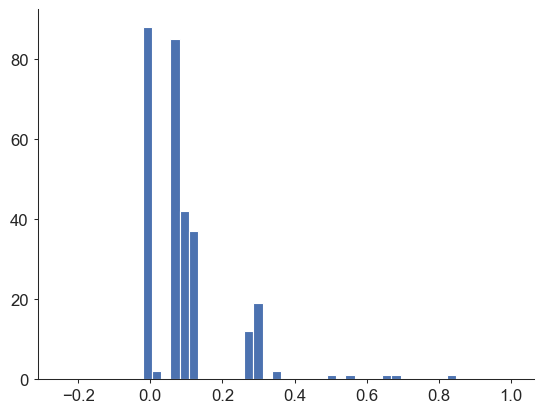

In [485]:
resp_largest_stat = df5.size_gain
resp_pref_stat = np.max((np.ones_like(resp_largest_stat), resp_largest_stat), axis=0)
suppression_index_stat = (resp_pref_stat - resp_largest_stat) / resp_largest_stat
plt.hist(suppression_index_stat, bins=np.linspace(-0.25, 1, 50))
np.mean(suppression_index_stat > 0.25)

Text(0, 0.5, 'SMI (running)')

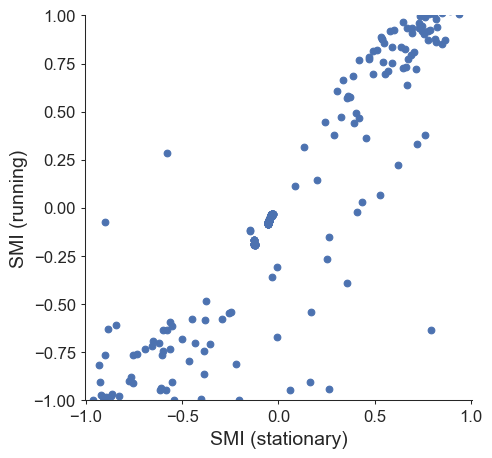

In [489]:
plt.figure(figsize=(5, 5))
plt.scatter(df5.smi, smi_run)
plt.axis('equal')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel("SMI (stationary)")
plt.ylabel("SMI (running)")

# Plot sample fits by model 5

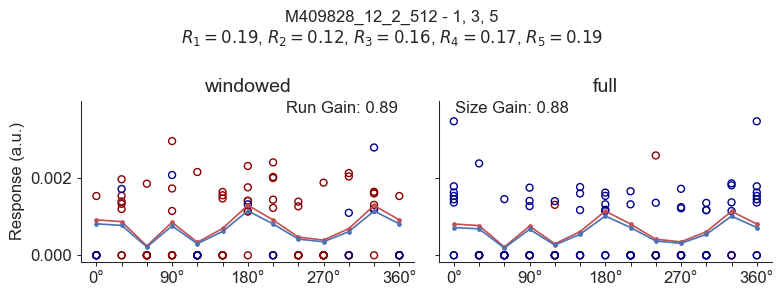

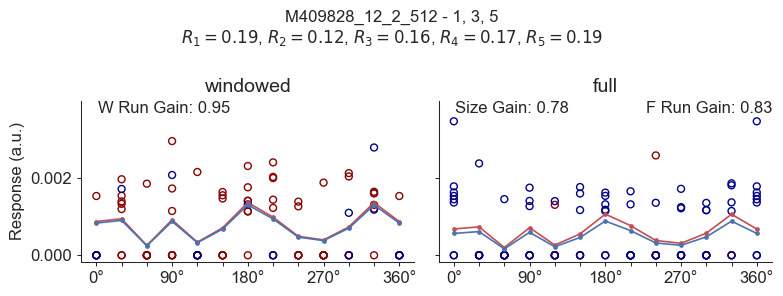

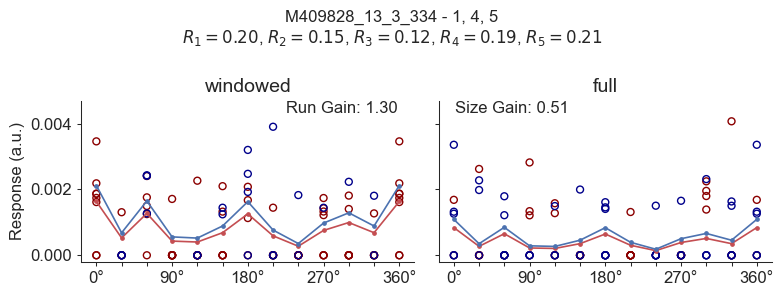

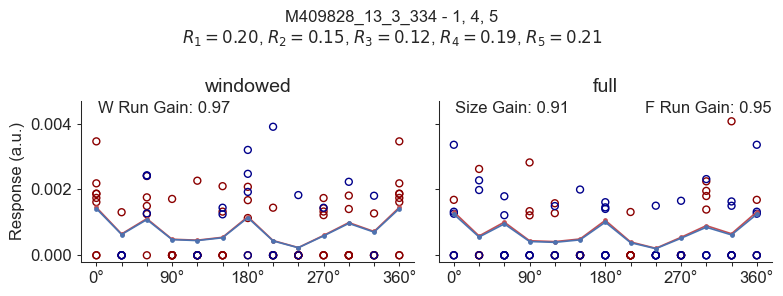

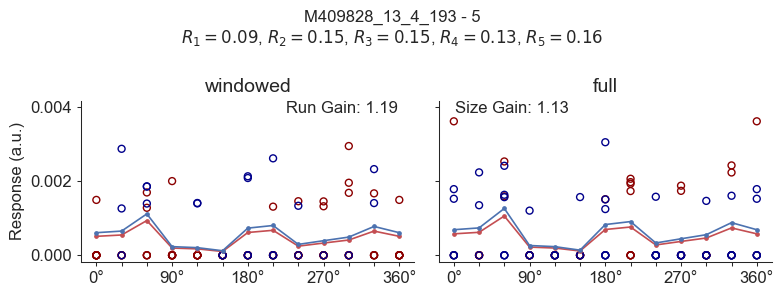

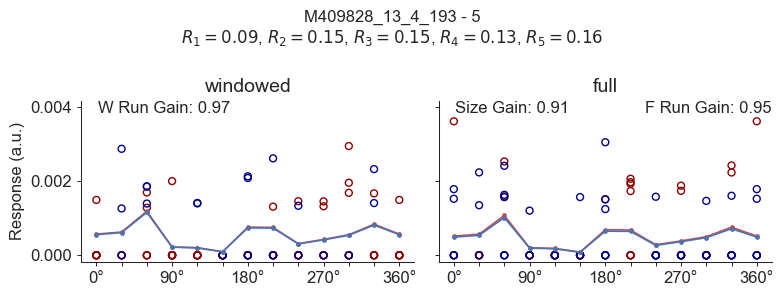

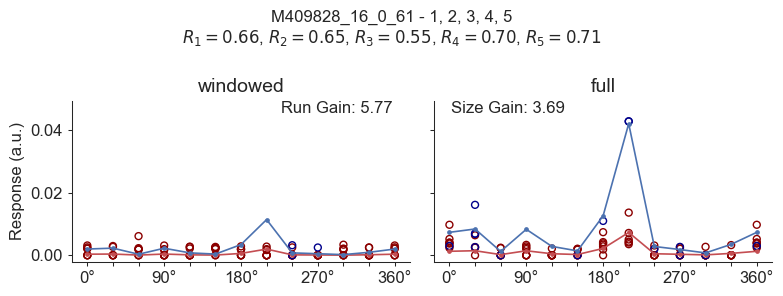

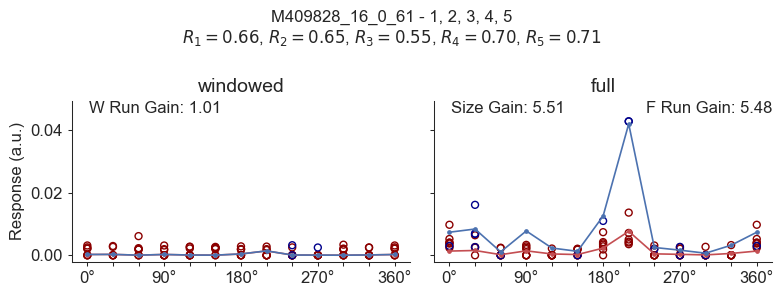

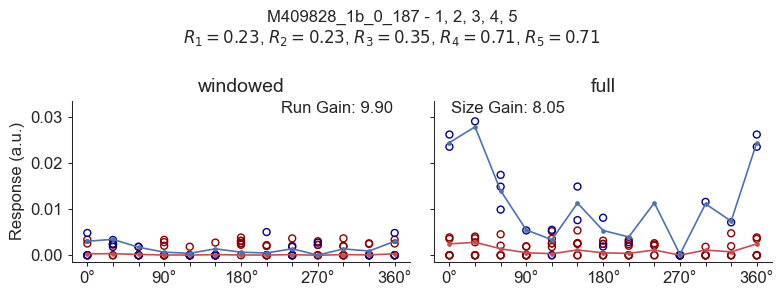

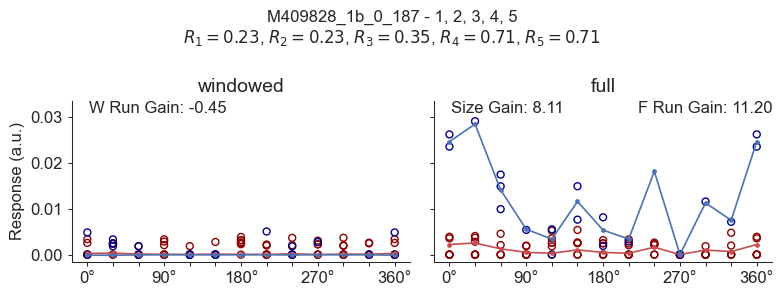

In [185]:
n = 5
x = model_df["r_valid_model5"].loc[roi_ids]
# x = x[x > 0.5]
plot_roi_ids = x.index[sorted(np.random.choice(len(x), n, replace=False))]
r_score_keys = [f"r_test_model{m}" for m in models.keys()]

for roi_id in plot_roi_ids:
    r_scores = model_df.loc[roi_id, r_score_keys].values
    r_scores_text = ", ".join([f"$R_{f'{i+1}'} = {r:.2f}$" for i, r in enumerate(r_scores)])

    for model_key in (4, 5):
        fig, axs = plotting.build_figure(figtitle=f"{roi_id} - {fit_df.at[roi_id, 'responsive_models']}\n{r_scores_text}", figscale=(4, 3))
        plotting.plot_trial_responses(roi_id, axs)
        
        # wrt = metrics_df.at[roi_id, "frac_resp_trials_w"]
        # frt = metrics_df.at[roi_id, "frac_resp_trials_f"]
        # for ax, rt in zip(axs, (wrt, frt)):
        #     ax.set_title(f"{ax.get_title()} - {rt:.2f}", fontsize=12)
        
        plotting.plot_model_fit(models, model_df, model_key=model_key, roi_id=roi_id, axs=axs)

In [427]:
df5

,roi_id,run_gain,run_gain_w,run_gain_f,run_gain_max,best_model,lmi,lmi_w,lmi_f
1,M409828_11_2_1,12.262586,19.320192,-2.330272,19.320192,5,0.849200,0.901576,2.503452
2,M409828_11_2_15,5.293016,2.386888,0.557601,2.386888,5,0.682187,0.409487,-0.284026
4,M409828_11_3_18,10.350155,53.583401,-10.682915,53.583401,5,0.823791,0.963359,1.206549
6,M409828_11_3_24,3.275902,7.718230,2.843119,7.718230,5,0.532262,0.770596,0.479589
7,M409828_11_3_5,1.851939,-0.211979,1.899592,1.899592,5,0.298723,-1.538004,0.310248
...,...,...,...,...,...,...,...,...,...
1067,M409828_1e_0_168,4.319992,0.656960,4.134615,4.134615,5,0.624060,-0.207030,0.610487
1068,M409828_1e_0_20,1.093540,0.983270,0.970384,0.983270,5,0.044680,-0.008435,-0.015031
1069,M409828_1e_0_33,2.104116,0.847723,2.077643,2.077643,5,0.355694,-0.082414,0.350152
1071,M409828_1e_0_51,0.956763,0.983336,0.970381,0.983336,5,-0.022096,-0.008402,-0.015032


In [430]:
df5[["run_gain_w", "run_gain_f"]]

,run_gain_w,run_gain_f
1,19.320192,-2.330272
2,2.386888,0.557601
4,53.583401,-10.682915
6,7.718230,2.843119
7,-0.211979,1.899592
...,...,...
1067,0.656960,4.134615
1068,0.983270,0.970384
1069,0.847723,2.077643
1071,0.983336,0.970381


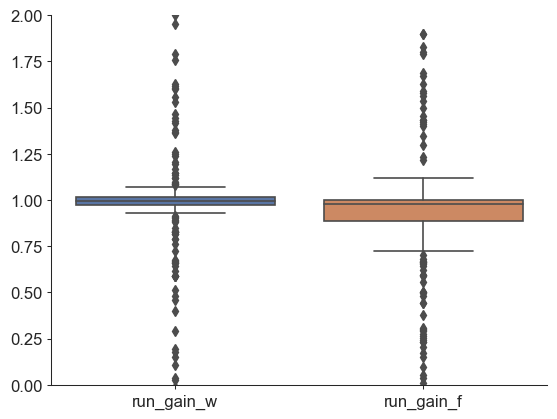

In [431]:
sns.boxplot(data=df5[["run_gain_w", "run_gain_f"]])
plt.ylim(0, 2)
plt.show()

(0.0, 2.0)

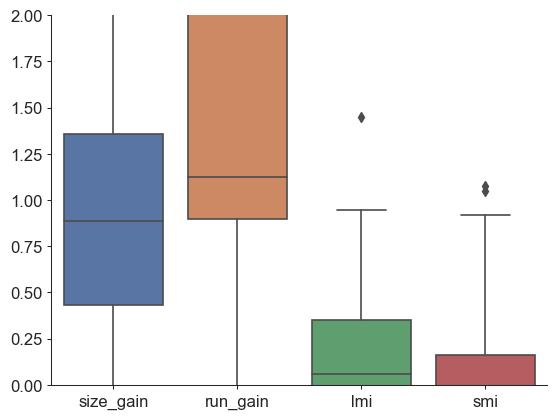

In [128]:
sns.boxplot(data=model4_df)
plt.ylim(0, 2)

Text(0.5, 1.0, 'SMI = index(S, 1)')

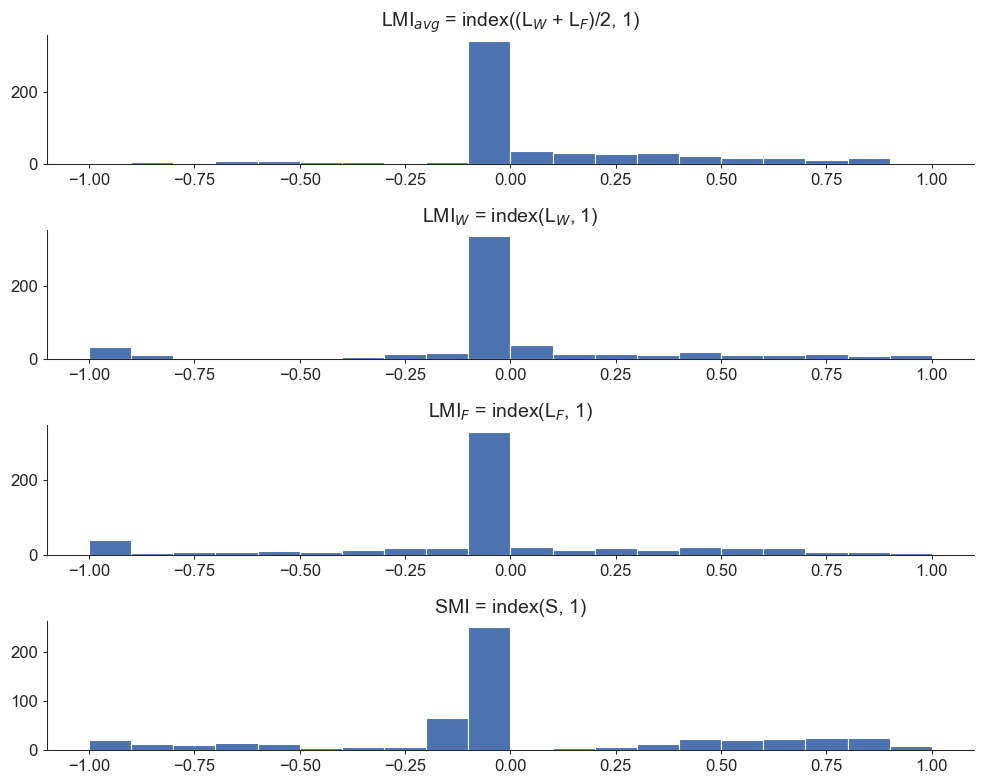

In [168]:
fig, axs = plt.subplots(figsize=(10, 8), nrows=4, tight_layout=True)
bins = np.arange(-1, 1.1, 0.1)
axs[0].hist(model5_df.lmi_avg, bins=bins)
axs[0].set_title("LMI$_{avg}$ = index((L$_W$ + L$_F$)/2, 1)")

axs[1].hist(model5_df.lmi_w, bins=bins)
axs[1].set_title("LMI$_W$ = index(L$_W$, 1)")

axs[2].hist(model5_df.lmi_f, bins=bins)
axs[2].set_title("LMI$_F$ = index(L$_F$, 1)")

axs[3].hist(model5_df.smi, bins=bins)
axs[3].set_title("SMI = index(S, 1)")

Text(0.5, 1.0, 'MODEL 4: SMI = index(S, 1)')

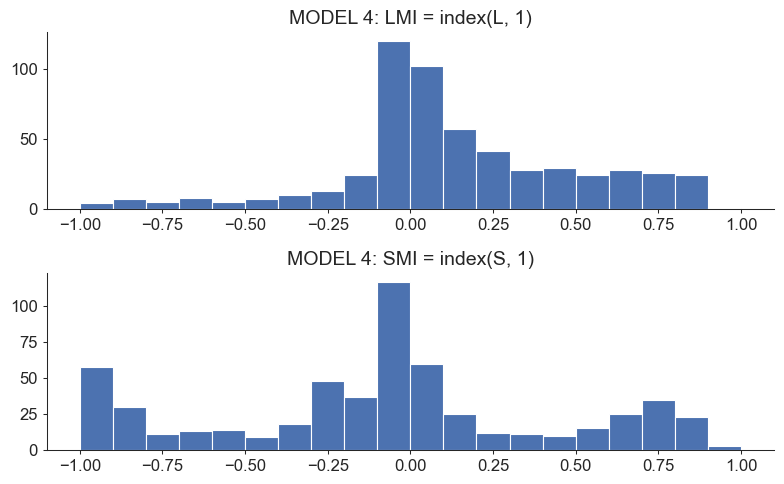

In [124]:
fig, axs = plt.subplots(figsize=(8, 5), nrows=2, tight_layout=True)
bins = np.arange(-1, 1.1, 0.1)
axs[0].hist(model4_df.lmi, bins=bins)
axs[0].set_title("MODEL 4: LMI = index(L, 1)")

axs[1].hist(model4_df.smi, bins=bins)
axs[1].set_title("MODEL 4: SMI = index(S, 1)")

# Running modulated SMI

(array([ 20.,  13.,  11.,  14.,  12.,   4.,   6.,   7.,  65., 252.,   3.,
          4.,   7.,  13.,  22.,  20.,  23.,  25.,  24.,   8.]),
 array([-1.00000000e+00, -9.00000000e-01, -8.00000000e-01, -7.00000000e-01,
        -6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
        -2.00000000e-01, -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
         2.00000000e-01,  3.00000000e-01,  4.00000000e-01,  5.00000000e-01,
         6.00000000e-01,  7.00000000e-01,  8.00000000e-01,  9.00000000e-01,
         1.00000000e+00]),
 <BarContainer object of 20 artists>)

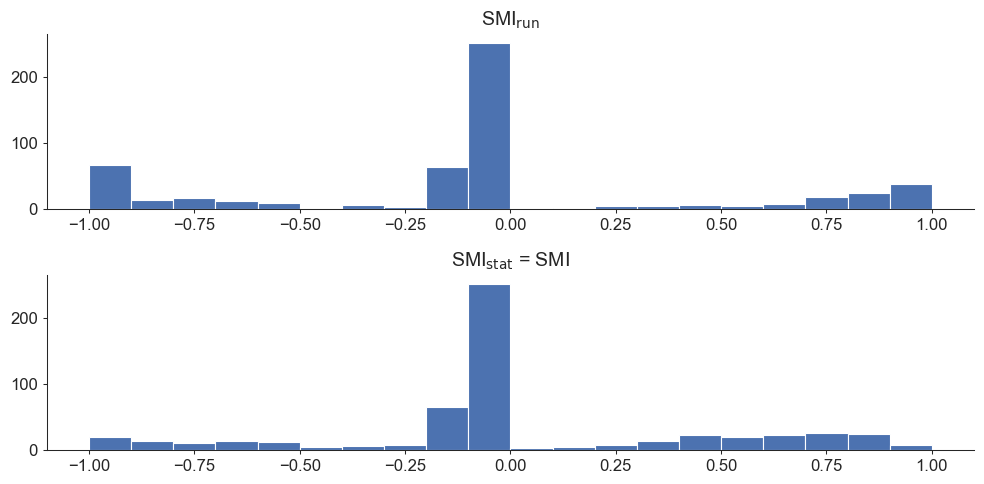

In [183]:
model5_df["smi_run"] = index_metric(model5_df["run_gain_f"] * model5_df["size_gain"], model5_df["run_gain_w"])

fig, axs = plt.subplots(figsize=(10, 5), nrows=2, tight_layout=True)
axs[0].set_title(r"SMI$_\mathrm{run}$")
axs[0].hist(model5_df.smi_run, bins=bins)
axs[1].set_title(r"SMI$_\mathrm{stat}$ = SMI")
axs[1].hist(model5_df.smi, bins=bins)